# Capital Spending Project Feasibility Assessment: Exploratory Analysis

Notes: 
- explore which agencies spend the highest % of money --> if a higher % of this data can be mapped to locations, then the project may be worth pursuing regardless of the % of other agency checks that can be mapped to locations 
- visualizations may provide insights into which agencies/departments should be prioritized in assessing feasibility
- visualizations can provide insights into change over time, trends, and projections of future capital spending projects might be useful in assessing feasibility as wel
- % of data that can be mapped to location by agency?

## Step 0: Setting up and importing data

In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import datetime
import matplotlib.font_manager
from thefuzz import fuzz
#import pandasql as ps


In [165]:
# --- checkbook nyc data
file_names = ['checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_0.csv', 
'checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_1.csv',
'checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_2.csv',
'checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_3.csv']
df0 = pd.read_csv(file_names[0])
df1 = pd.read_csv(file_names[1])
df2 = pd.read_csv(file_names[2])
df3 = pd.read_csv(file_names[3])
frames = [df0, df1, df2, df3]
df = pd.concat(frames)

In [166]:
# --- budget codes
bc = pd.read_csv('ref_budget_code_list.csv')

In [167]:
# --- top 10 acronyms
### maybe update to include all of them
ag_ac = {
    'department of education':'DOE', 
'school construction authority':'SCA',
'department of environmental protection':'DEP',
'housing preservation and development':'HPD',
'department of parks and recreation':'DPR',
'department of transportation':'DOT',
'department of citywide administrative services':'DCAS',
'department of small business services':'SBS',
'health and hospitals corporation':'HHC',
'department of sanitation':'DSNY'
}

## Step 1: Data Cleaning

In [168]:
print("There are {} rows".format(df.shape[0]))
print("There are {} columns".format(df.shape[1]))
print("The columns are as follows: {}".format(df.dtypes))
df.head(5)

There are 1990934 rows
There are 20 columns
The columns are as follows: Agency                        object
Associated Prime Vendor      float64
Budget Code                   object
Capital Project               object
Check Amount                 float64
Contract ID                   object
Contract Purpose              object
Department                    object
Document ID                   object
Emerging Business             object
Expense Category              object
Fiscal year                    int64
Industry                      object
Issue Date                    object
M/WBE Category                object
Payee Name                    object
Spending Category             object
Sub Contract Reference ID    float64
Sub Vendor                    object
Woman Owned Business          object
dtype: object


,Agency,Associated Prime Vendor,Budget Code,Capital Project,Check Amount,Contract ID,Contract Purpose,Department,Document ID,Emerging Business,Expense Category,Fiscal year,Industry,Issue Date,M/WBE Category,Payee Name,Spending Category,Sub Contract Reference ID,Sub Vendor,Woman Owned Business
0,Transit Authority,NaN,"BUSB (MTA, NYCT: PURCHASE 126 HYBRID BUSES)",998CAP2024 005,99999999.95,CT199820231408687,Bus Purch Track Replace Switch Replace Rail Su...,400-998-169,20230231715-1-DSB-EFT,No,CAPITAL PURCHASED EQUIPMENT,2023,Standardized Services,2022-12-21,Individuals and Others,METROPOLITAN TRANSPORTATION AUTHORITY,Capital Contracts,NaN,No,No
1,Transit Authority,NaN,"SAPS (MTA / NYCT: SUBWAY ACTION PLAN, SIGNAL A)",998CAPSAP 003,99999999.59,CT199820191409664,Subway Action Plan Signal Improvement & Modern...,400-998-169,20190025861-1-015-MD1,No,IOTB CONSTRUCTION,2019,Standardized Services,2018-10-30,Individuals and Others,METROPOLITAN TRANSPORTATION AUTHORITY,Capital Contracts,NaN,No,No
2,Department of Education,NaN,E706 (IMPLEMENTATION OF THE SEVENTH FIVE-YEAR),040SCA22 030,99999999.00,PON1040SCA20-24MC,NaN,IMPLEMENTATION OF THE SEVENTH FIVE-YEAR,20220448629-1-DSB-EFT,No,ADMINISTRATIVE EXPENSES,2022,NaN,2022-05-27,Individuals and Others,NYC SCHOOL CONSTRUCTION AUTHORITY,Capital Contracts,NaN,No,No
3,Department of Education,NaN,E706 (IMPLEMENTATION OF THE SEVENTH FIVE-YEAR),040SCA21 030,99999999.00,PON1040SCA20-24MC,NaN,IMPLEMENTATION OF THE SEVENTH FIVE-YEAR,20220448626-1-DSB-EFT,No,CONSTRUCTION-BUILDINGS,2022,NaN,2022-05-27,Individuals and Others,NYC SCHOOL CONSTRUCTION AUTHORITY,Capital Contracts,NaN,No,No
4,Department of Education,NaN,E706 (IMPLEMENTATION OF THE SEVENTH FIVE-YEAR),040SCA21 030,99999999.00,PON1040SCA20-24MC,NaN,IMPLEMENTATION OF THE SEVENTH FIVE-YEAR,20220354644-1-DSB-EFT,No,CONSTRUCTION-BUILDINGS,2022,NaN,2022-03-25,Individuals and Others,NYC SCHOOL CONSTRUCTION AUTHORITY,Capital Contracts,NaN,No,No


In [169]:
# --- budget code data cleaning
bc = bc.dropna()
subway_bc = bc[bc['Budget Code Name'].str.contains('s')]
bc.shape

(83919, 2)

In [170]:
# --- data cleaning 
df['Issue Date'] = pd.to_datetime(df['Issue Date'])
df['Fiscal year'] = pd.to_datetime(df['Fiscal year'], format='%Y')
df['Agency'] = df['Agency'].str.lower()
df['Budget Code'] = df['Budget Code'].str.lower()
df['Contract Purpose'] = df['Contract Purpose'].str.lower()
df['Spending Category'] = df['Spending Category'].str.lower()
df['Agency Code'] = df['Agency'].map(ag_ac)

# W/MBE category to boolean
# Women owned business to boolean
# Emerging business to boolean

## Step 2: Exploration

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990934 entries, 0 to 490933
Data columns (total 21 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   Agency                     object        
 1   Associated Prime Vendor    float64       
 2   Budget Code                object        
 3   Capital Project            object        
 4   Check Amount               float64       
 5   Contract ID                object        
 6   Contract Purpose           object        
 7   Department                 object        
 8   Document ID                object        
 9   Emerging Business          object        
 10  Expense Category           object        
 11  Fiscal year                datetime64[ns]
 12  Industry                   object        
 13  Issue Date                 datetime64[ns]
 14  M/WBE Category             object        
 15  Payee Name                 object        
 16  Spending Category          object    

In [172]:
# --- How much money is being disbursed total?
total_check_sum = df['Check Amount'].sum()
print("Total check amounts disbursed, 2010-present: {}".format(total_check_sum))
print("Total check amounts disbursed per year, 2010-present, sorted decreasing: {}".format(df.groupby('Fiscal year')['Check Amount'].sum().sort_values(ascending=False)))

# --- percentage check sums by agency
total_per_agency = df.groupby('Agency')['Check Amount'].sum()
percentage_per_agency = (total_per_agency / total_check_sum) * 100
pct_by_agency_df = pd.DataFrame({'Agency' : percentage_per_agency.index, 'Percentage': percentage_per_agency.values})
pct_by_agency_df = pct_by_agency_df.sort_values('Percentage', ascending=False)
print("Top 10 spending agencies by percent of total amount of checks dispersed: {}".format(pct_by_agency_df[:10]))

Total check amounts disbursed, 2010-present: 152129194370.26013
Total check amounts disbursed per year, 2010-present, sorted decreasing: Fiscal year
2023-01-01    1.293679e+10
2019-01-01    1.265488e+10
2022-01-01    1.257962e+10
2020-01-01    1.241044e+10
2011-01-01    1.137676e+10
2018-01-01    1.131402e+10
2021-01-01    1.094319e+10
2017-01-01    1.080665e+10
2016-01-01    1.071054e+10
2012-01-01    1.040313e+10
2014-01-01    1.010988e+10
2013-01-01    9.946660e+09
2015-01-01    9.660733e+09
2010-01-01    6.275899e+09
Name: Check Amount, dtype: float64
Top 10 spending agencies by percent of total amount of checks dispersed:                                             Agency  Percentage
7                          department of education   23.168862
26                   school construction authority   22.704781
8           department of environmental protection   14.243126
17                    department of transportation    7.408128
20            housing preservation and development

Insights: 
- Top 5 agencies by percentage make up vast majority of total % money spent (~75%). In order, these are DOE, SCA, DEP, DOT, HPD
- Biggest spending years are 2023, 2019, 2022, 2020, 2011 in that order

## Step 3: Visualization

Guiding questions:
- Which agencies spent the most on capital projects?
- Which expense categories spent the most on capital projects?
- Are there noticeable time trends regarding the amount of money spent by agency on capital projects?

In [174]:

# --- set up custom viz settings 
l_blue = "#177e89"
d_blue = "#084c61"
orange = "#db3a34"
yellow = "#ffc857"
brown = "#323031" 
grey = "#868686"
black = "#333"

colors = [ l_blue, d_blue, orange, yellow, grey, brown, black ]


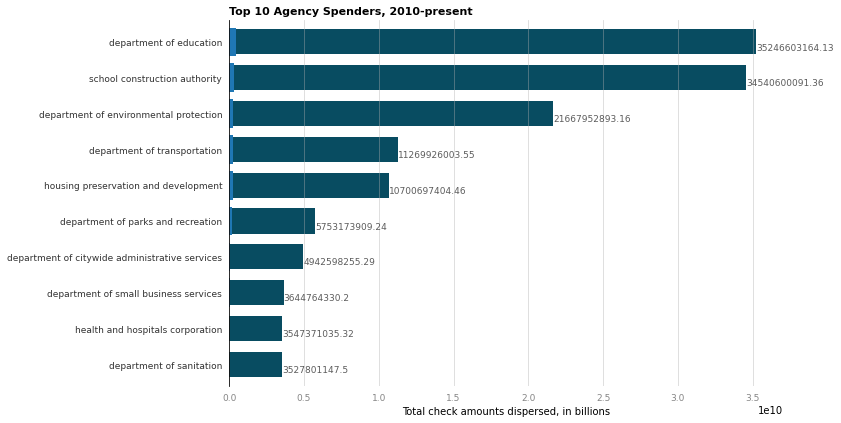

In [175]:
# --- SPENDING BY AGENCY
spending_by_agency = df.groupby('Agency')['Check Amount'].sum().sort_values(ascending=True)

# --- plot --- 
fig, axs = plt.subplots(figsize=(12,6), nrows = 1)
ax = axs
spending_by_agency.tail(10).plot(kind='barh', ax=ax, width=0.7, color=d_blue)

for p in ax.patches:
    ax.annotate( str(p.get_width()), (p.get_width() + 0.75 , p.get_y()+0.075 ), fontsize=9, fontweight='light', alpha = 0.8, color=black, va='bottom')

# tick marks and 0-line
sns.despine(ax=ax, bottom = True )
ax.tick_params( left=False, bottom=False )
ax.set_title("Top 10 Agency Spenders, 2010-present", fontsize=11, fontweight="bold", loc="left")
ax.grid(axis='x', linestyle='-', alpha=0.5, zorder = 0 )
ax.set_ylabel("")
ax.set_xlabel("Total check amounts dispersed, in billions")
plt.tight_layout( h_pad=1 )

# change x-tick fonts
for tick in ax.get_xticklabels():
    tick.set_fontsize(9)
    tick.set_color( grey )

# change y-tick fonts
for tick in ax.get_yticklabels():
    tick.set_fontsize(9)
    tick.set_color( black )

plt.barh(spending_by_agency.index, spending_by_agency)
plt.show()

Insights:
- DOE and SCA are the clear spending leaders, followed by DEP; may prove valuable to focus our exploration/analysis on
- nature of the top 5 agencies implies spending on fixed assets which are likely traceable to location information (schools, roads, waterways, housing)

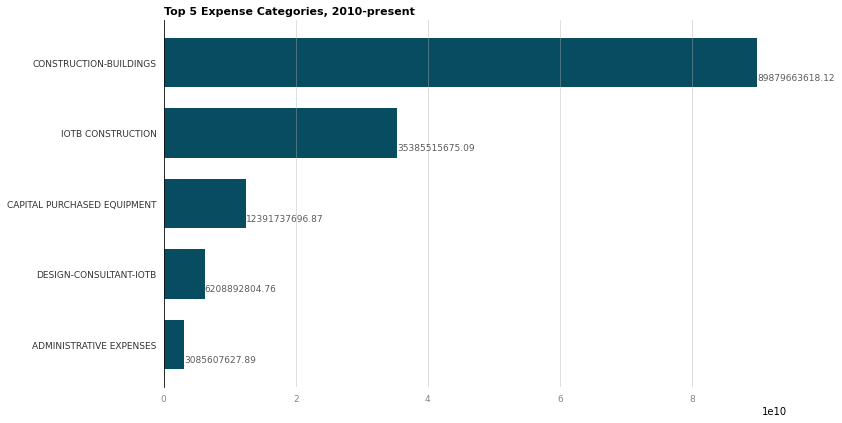

In [176]:
# --- SPENDING BY EXPENSE CATEGORY

spending_by_exp_cat = df.groupby('Expense Category')['Check Amount'].sum().sort_values(ascending=True)

# --- plot --- 
fig, axs = plt.subplots(figsize=(12,6), nrows = 1)
ax = axs
spending_by_exp_cat.tail(5).plot(kind='barh', ax=ax, width=0.7, color=d_blue)

for p in ax.patches:
    ax.annotate( str(p.get_width()), (p.get_width() + 0.75 , p.get_y()+0.075 ), fontsize=9, fontweight='light', alpha = 0.8, color=black, va='bottom')

sns.despine(ax=ax, bottom = True )
ax.tick_params( left=False, bottom=False )
ax.set_title("Top 5 Expense Categories, 2010-present", fontsize=11, fontweight="bold", loc="left")
ax.grid(axis='x', linestyle='-', alpha=0.5, zorder = 0 )
ax.set_ylabel("") # remove y-axis label
plt.tight_layout( h_pad=1 )

for tick in ax.get_xticklabels():
    tick.set_fontsize(9)
    tick.set_color( grey )

for tick in ax.get_yticklabels():
    tick.set_fontsize(9)
    tick.set_color( black )

plt.barh(spending_by_exp_cat.index, spending_by_exp_cat)
plt.show()

Insights:
- Construction-Buildings spends the most by far, followed by IOTB-Construction (improvements other than buildings); promising as the construction of fixed assets implies some amount of location information, and this again makes up the majority of the data

In [177]:
# --- Time series / heat map data

# calculate percentages
total_by_fy = df.groupby('Fiscal year')['Check Amount'].sum()
grouped_data = df.groupby(['Fiscal year', 'Agency'])['Check Amount'].sum().reset_index()

temp_df = grouped_data.copy()
temp_df.loc[:, 'Percent of total check amounts, by FY'] = (temp_df['Check Amount'] / temp_df['Fiscal year'].map(total_by_fy)) * 100

temp_df.head(5)


pct_by_agency_by_fy = temp_df.groupby([pd.Grouper(key = 'Fiscal year'), 'Agency'], as_index = False
).agg({'Percent of total check amounts, by FY':'first', 'Fiscal year':'first'}).sort_values(by = 'Fiscal year', ascending = True)
top_10_pct_by_agency_by_fy = pct_by_agency_by_fy[pct_by_agency_by_fy['Agency'].isin(pct_by_agency_df['Agency'].head(10))]
top_10_pct_by_agency_by_fy['Agency Code'] = pct_by_agency_by_fy['Agency'].map(ag_ac)
#pct_by_agency_by_fy.head(5)



print(top_10_pct_by_agency_by_fy[top_10_pct_by_agency_by_fy['Agency Code']=='DOE'])

                      Agency  Percent of total check amounts, by FY  \
7    department of education                              25.496815   
36   department of education                              19.339766   
64   department of education                              20.552196   
92   department of education                              20.911188   
120  department of education                              21.802320   
148  department of education                              25.655889   
175  department of education                              27.076393   
202  department of education                              25.363379   
229  department of education                              24.302614   
257  department of education                              20.347879   
284  department of education                              22.637473   
311  department of education                              24.095319   
337  department of education                              21.972951   
364  d

/var/folders/7p/9414x_x93rvb4p6kc2ny_wl00000gn/T/ipykernel_20469/380055454.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_pct_by_agency_by_fy['Agency Code'] = pct_by_agency_by_fy['Agency'].map(ag_ac)


/var/folders/7p/9414x_x93rvb4p6kc2ny_wl00000gn/T/ipykernel_20469/1195045689.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = top_10_pct_by_agency_by_fy.pivot('Agency Code', 'Fiscal year', 'Percent of total check amounts, by FY')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


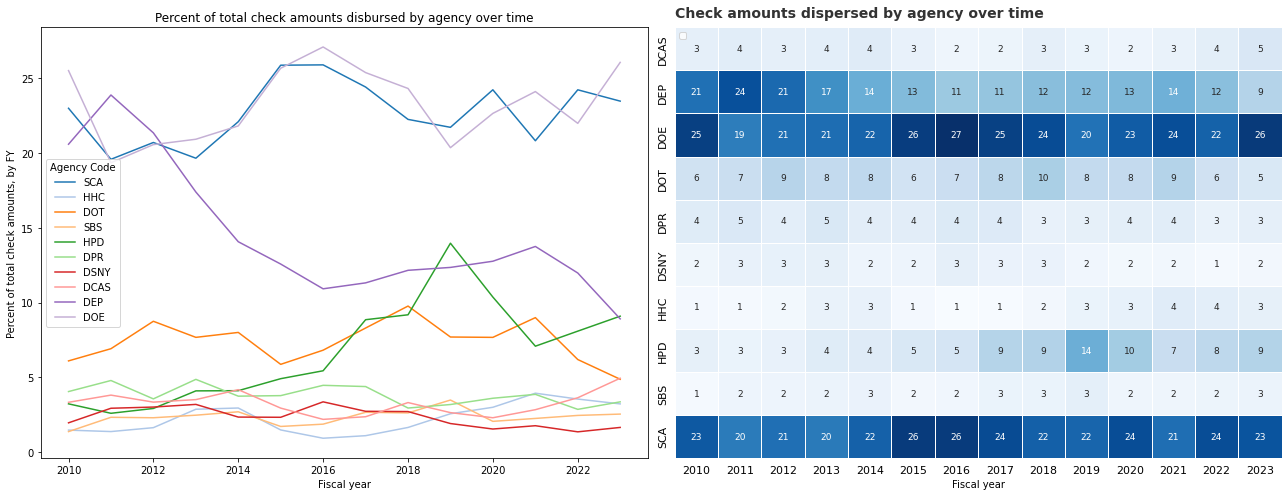

In [178]:
# --- PLOT
fig,axs = plt.subplots( figsize = (18,7) , ncols = 2 )

# --- time series
ax = axs[0]
sns.lineplot(
    data = top_10_pct_by_agency_by_fy,
    x = 'Fiscal year',
    y = 'Percent of total check amounts, by FY',
    hue = 'Agency Code',
    ax= ax ,
    palette = 'tab20',
)

ax.set_title('Percent of total check amounts disbursed by agency over time')

# --- heat map
ax = axs[1]
pivot_data = top_10_pct_by_agency_by_fy.pivot('Agency Code', 'Fiscal year', 'Percent of total check amounts, by FY')
sns.heatmap(
    pivot_data,
    cmap = 'Blues',
    annot = True,
    fmt = '.0f',
    annot_kws = {'fontsize':9},
    cbar = False,
    linewidths = 1,
    linecolor = 'w',
    ax = ax
)

ax.legend( loc = 'upper left', bbox_to_anchor = (0,1), ncol = 1, fontsize = 9 )

# change x-tick format
ax.set_xticklabels( [ x.strftime('%Y') for x in pivot_data ] , rotation = 0, ha = 'center' )
ax.tick_params( axis = 'both', which = 'both', left = False, bottom = False, labelsize = 11 )
ax.set_ylabel('')
ax.set_title( "Check amounts dispersed by agency over time", fontsize = 14, fontweight = 'bold', loc = 'left', color = black, pad = 10 )

plt.tight_layout( w_pad = 1 );

Notes to improve visual:
- Move legend
- Change colors, overall think about design as a tool for communicating to DAvid/other stakeholders our argument (which I think is that this is feasible... but need to consult with Dea/team on that)
- fix x-ticks on time series

Insights: 
- What was going on with HPD 2016-2020? % total spending has increased significantly over that period and is still higher than before. HPD spends a lot on fixed assets (obviously), so again promising for feasibility.
- DEP was previously 3rd place for spending, and has been trending downward since 2015

## Fuzzy string matching

In [182]:
#  --- fuzzy string matching test
fixed_assets = pd.Series(open('fixed_assets.txt', 'r').read().splitlines())

# use partial token ratio to decide if something is a match, 
# and then calculate % of rows that are a match
# filter to just include DOE for now bc of size
df['Fixed Asset Match'] = 0

filtered_df = df[df['Agency Code']=='DOE']
filtered_df.reset_index(drop=True, inplace=True)

# --- how to do this for a BIG dataset... 
for asset in fixed_assets:
    mask = ~filtered_df['Budget Code'].isna()
    filtered_df.loc[mask, 'Fixed Asset Match'] += filtered_df.loc[mask, 'Budget Code'].apply(lambda x: fuzz.partial_ratio(asset, x) > 70)

# Calculate the percentage of matches
total_rows = len(filtered_df)
num_matches = filtered_df['Fixed Asset Match'].sum()
percentage_of_matches = (num_matches / total_rows) * 100

print("Percentage of DOE Budget Codes that reference fixed assets, threshold 70: {}".format(percentage_of_matches))


Percentage of DOE Budget Codes that reference fixed assets, threshold 70: 51.5063731170336


Results: 
- Filtered to only include DOE as a test (to limit size of data)
- When threshold > 70 for partial fuzz ratio, % matches is 51.506
- When threshold > 50, % matches is 


Notes: 
- dataset is too big to iterate over the whole thing. Use paralelle processing library, rapidfuzz package (approximate string matching), or randomly sample the data for now? Then find a longer-term solution
- what is a reasonable way of subsetting the data to draw valid conclusions about the feasibility of extracting location information?
- how do I evaluate that this is
- this is all fine and dandy but what if the partial ratio being high doesn't actually mean it's easy to map these rows to geometries / locations? need to join on CPDB / FacDB to assess